# MRI Brain Tumor Classification
In this notebook, I compare EfficientNetB0 with and without pretrained ImageNet weights, to a custom CNN on the task of classifying MRIs of brain tumors.

Dataset source: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

The four classes in this dataset are: no tumor, pituitary tumor, menigioma, and glioma.

In [1]:
from keras.applications import EfficientNetB0
from keras.layers import Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D, ReLU
from keras.layers import Dropout, Input, Softmax, RandomFlip, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.regularizers import L2
from keras.utils import image_dataset_from_directory

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

## 1. Load Data

In [2]:
img_rows = 200
img_cols = 200
channels = 3

def load_dataset(path):
    dataset = image_dataset_from_directory(directory = path, 
                                           label_mode = 'categorical', 
                                           color_mode = 'rgb', 
                                           shuffle = False, 
                                           batch_size = None,
                                           image_size = (img_rows, img_cols),
                                           crop_to_aspect_ratio = True)
    return dataset

dataset1 = load_dataset('Data/Training')
dataset2 = load_dataset('Data/Testing')

images = []
labels = []
for (image, label) in dataset1:
    images.append(image)
    labels.append(label)

for (image, label) in dataset2:
    images.append(image)
    labels.append(label)
    
images = np.asarray(images)
labels = np.asarray(labels)
labels = labels.astype(np.uint8)

images, labels = shuffle(images, labels, random_state = 10)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1, random_state = 36)

Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


## 2. Preview Data

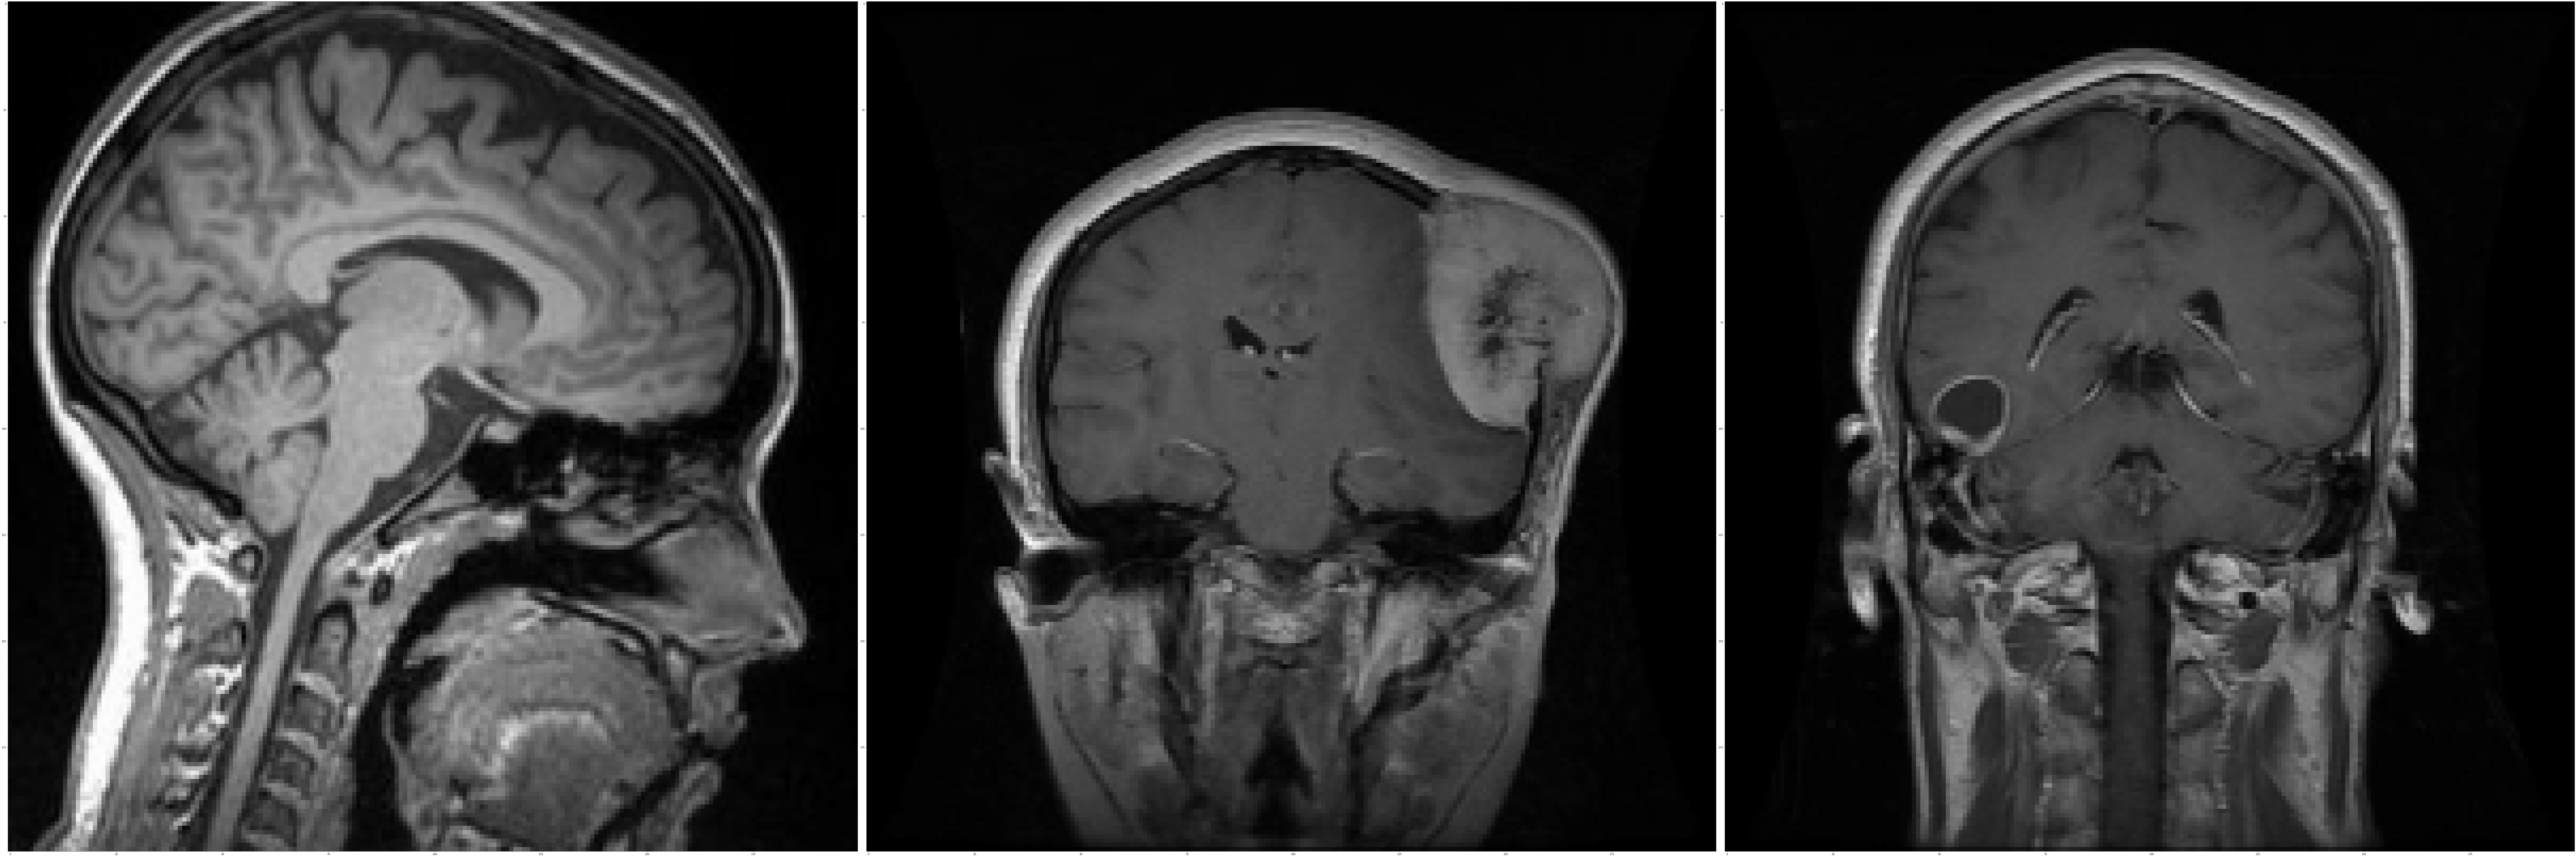

In [3]:
plt.figure(figsize = (50 * 3, 50))

for i in range(3):
    image = x_train[i].astype(np.uint8)
    plt.subplot(1, 3, i + 1)
    plt.imshow(image)

plt.tight_layout()
plt.show()

## 3. Define Visualization Function

In [29]:
plt.rcParams.update({'font.size': 12})
def plot_performance(history, epochs, metric):
    fig, ax = plt.subplots(1, 1)
    plt.title('Train and Validation ' + metric.title())
    
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric.title())
    
    x = list(range(1, epochs + 1))
    vy = history.history['val_' + metric]
    ty = history.history[metric]
    
    ax.plot(x, vy, label = 'Validation')
    ax.plot(x, ty, label = 'Train')
    
    plt.legend()
    plt.grid()
    fig.canvas.draw()

## 4. Custom CNN
### 4.1 Define Custom CNN

In [7]:
def create_custom_cnn_model():
    regularizer = L2(0.001)
    model = Sequential()
    
    model.add(Input(shape = (img_rows, img_cols, channels)))
    model.add(Conv2D(128, kernel_size = (6, 6), strides = (4, 4), padding = 'same',
                      kernel_regularizer = regularizer))
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size = (3, 3), kernel_regularizer = regularizer))
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(32, kernel_size = (3, 3), kernel_regularizer = regularizer))
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(4, kernel_size = (3, 3)))
    model.add(ReLU())

    model.add(GlobalAveragePooling2D())
    model.add(Softmax())

    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

### 4.2 Train Custom CNN

In [9]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, 
                              min_delta = 0.001, mode = 'auto', verbose = 1)

custom_cnn = create_custom_cnn_model()
custom_cnn_history = custom_cnn.fit(x = x_train, y = y_train, validation_data = (x_test, y_test),
                                    epochs = 30, batch_size = 32, callbacks = [reduce_lr])

Epoch 1/30
92/92 [==============================] - 4s 13ms/step - loss: 1.1305 - accuracy: 0.6146 - val_loss: 3.5275 - val_accuracy: 0.1835 - lr: 0.0010
Epoch 2/30
92/92 [==============================] - 1s 9ms/step - loss: 0.8723 - accuracy: 0.7337 - val_loss: 1.1186 - val_accuracy: 0.6361 - lr: 0.0010
Epoch 3/30
92/92 [==============================] - 1s 10ms/step - loss: 0.7253 - accuracy: 0.7974 - val_loss: 0.9610 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/30
92/92 [==============================] - 1s 10ms/step - loss: 0.6139 - accuracy: 0.8403 - val_loss: 1.0473 - val_accuracy: 0.6330 - lr: 0.0010
Epoch 5/30
91/92 [============================>.] - ETA: 0s - loss: 0.5513 - accuracy: 0.8760
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
92/92 [==============================] - 1s 9ms/step - loss: 0.5511 - accuracy: 0.8761 - val_loss: 1.5924 - val_accuracy: 0.4404 - lr: 0.0010
Epoch 6/30
92/92 [==============================] - 1s 10ms/step - loss: 

### 4.4 Visualize Custom CNN Performance

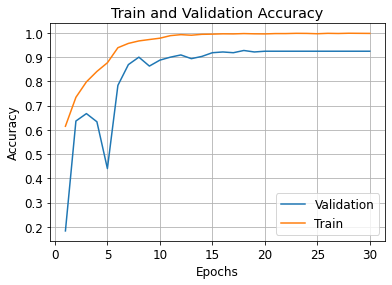

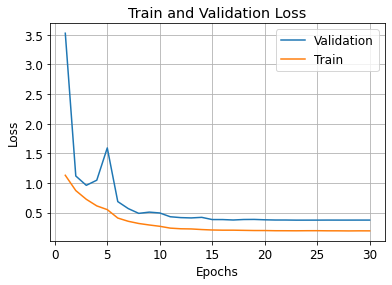

In [30]:
plot_performance(custom_cnn_history, 30, 'accuracy')
plot_performance(custom_cnn_history, 30, 'loss')

## 5. EfficientNetB0
### 5.1 Define EfficientNetB0 Model

In [11]:
def create_effnet_model(weights = None):
    model = Sequential()
    model.add(Input(shape = (img_rows, img_cols, channels)))
    model.add(RandomFlip('horizontal'))

    model.add(EfficientNetB0(weights = weights, include_top = False))

    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(4, activation = 'softmax'))

    model.build()
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

### 5.2 Train EfficientNetB0 Model From Scratch

In [12]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, 
                              min_delta = 0.01, mode = 'auto', verbose = 1)

vanilla_effnet = create_effnet_model(weights = None)
vanilla_effnet_history = vanilla_effnet.fit(x = x_train, y = y_train, validation_data = (x_test, y_test),
                                            epochs = 30, batch_size = 32, callbacks = [reduce_lr])

Epoch 1/30
92/92 [==============================] - 23s 165ms/step - loss: 1.4006 - accuracy: 0.4093 - val_loss: 1.5628 - val_accuracy: 0.3211 - lr: 0.0010
Epoch 2/30
92/92 [==============================] - 13s 145ms/step - loss: 1.0573 - accuracy: 0.6003 - val_loss: 1.5302 - val_accuracy: 0.1529 - lr: 0.0010
Epoch 3/30
92/92 [==============================] - ETA: 0s - loss: 0.8388 - accuracy: 0.6691
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
92/92 [==============================] - 13s 145ms/step - loss: 0.8388 - accuracy: 0.6691 - val_loss: 1.9468 - val_accuracy: 0.1529 - lr: 0.0010
Epoch 4/30
92/92 [==============================] - 13s 144ms/step - loss: 0.6192 - accuracy: 0.7620 - val_loss: 3.6032 - val_accuracy: 0.1468 - lr: 3.0000e-04
Epoch 5/30
92/92 [==============================] - ETA: 0s - loss: 0.4868 - accuracy: 0.8199
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
92/92 [==============================] - 13

### 5.3 Visualize Vanilla-EfficientNetB0 Performance

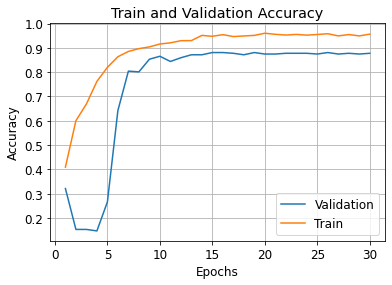

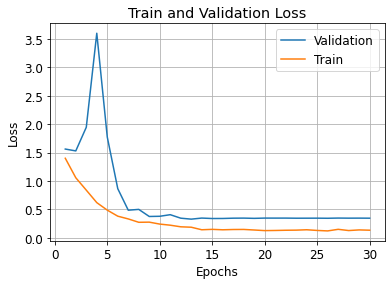

In [31]:
plot_performance(vanilla_effnet_history, 30, 'accuracy')
plot_performance(vanilla_effnet_history, 30, 'loss')

### 5.4 Train EfficientNetB0 With Pretrained ImageNet Weights

In [15]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, 
                              min_delta = 0.01, mode = 'auto', verbose = 1)

imagenet_effnet = create_effnet_model(weights = 'imagenet')
imagenet_effnet_history = imagenet_effnet.fit(x = x_train, y = y_train, validation_data = (x_test, y_test),
                                              epochs = 30, batch_size = 32, callbacks = [reduce_lr])

Epoch 1/30
92/92 [==============================] - 21s 154ms/step - loss: 0.4095 - accuracy: 0.8498 - val_loss: 0.4090 - val_accuracy: 0.8991 - lr: 0.0010
Epoch 2/30
92/92 [==============================] - 13s 142ms/step - loss: 0.1918 - accuracy: 0.9377 - val_loss: 0.1951 - val_accuracy: 0.9480 - lr: 0.0010
Epoch 3/30
92/92 [==============================] - 13s 142ms/step - loss: 0.1396 - accuracy: 0.9513 - val_loss: 0.3911 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 4/30
92/92 [==============================] - ETA: 0s - loss: 0.0974 - accuracy: 0.9653
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
92/92 [==============================] - 13s 143ms/step - loss: 0.0974 - accuracy: 0.9653 - val_loss: 0.4509 - val_accuracy: 0.8838 - lr: 0.0010
Epoch 5/30
92/92 [==============================] - 13s 141ms/step - loss: 0.0378 - accuracy: 0.9901 - val_loss: 0.1064 - val_accuracy: 0.9694 - lr: 3.0000e-04
Epoch 6/30
92/92 [==============================] - 13s 1

### 5.5 Visualize ImageNet-EfficientNetB0 Performance

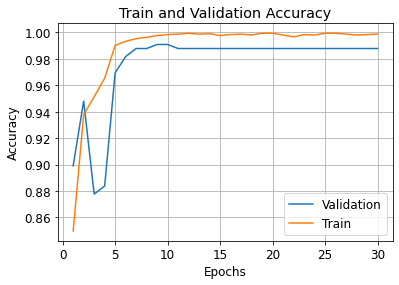

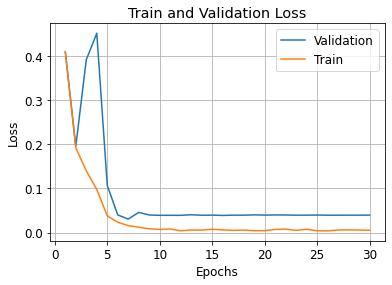

In [32]:
plot_performance(imagenet_effnet_history, 30, 'accuracy')
plot_performance(imagenet_effnet_history, 30, 'loss')

## 6. Final Comparison

In [27]:
def compare_performance(models, epochs, metric):
    fig, ax = plt.subplots(1, 1)
    plt.title('Validation ' + metric.title())
    
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric.title())
    x = list(range(1, epochs + 1))
    
    for model in models:
        y = model['history'].history['val_' + metric]
        ax.plot(x, y, label = model['name'])

    plt.legend()
    plt.grid()
    fig.canvas.draw()

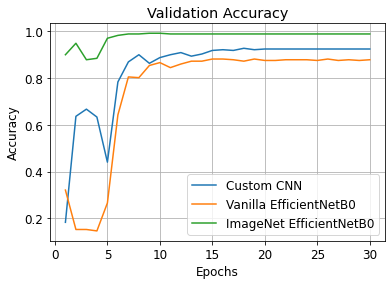

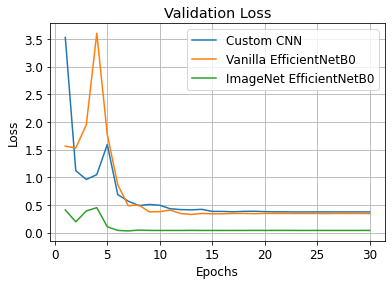

In [28]:
models = [{'name': 'Custom CNN', 'history': custom_cnn_history},
          {'name': 'Vanilla EfficientNetB0', 'history': vanilla_effnet_history},
          {'name': 'ImageNet EfficientNetB0', 'history': imagenet_effnet_history}]
compare_performance(models, 30, 'accuracy')
compare_performance(models, 30, 'loss')

Ultimately, EfficientNetB0 with pretrained ImageNet weights (ImageNet-EfficientNetB0) performed the best of the three models, achieving a maximum accuracy of 99%. The Custom CNN came in second with a maximum accuracy of 92%, followed by EfficientNetB0 trained from scratch (Vanilla-EfficientNetB0) with a maximum accuracy of only 88%.